## TODO:

1. incorporate `PrettyDuration` into `JagularFileMap` and update `__repr__` [DONE!]
1. split out `pairwise` and `is_sorted` to `utils` [DONE!]
1. fix issue of `header_size`
1. fix test data [DONE!]
1. write actual utiity function to return data and/or list of required files
1. finish `NotImplementedError` functions
1. deal with duplicates, and overlaps
1. consider graceful abort?
1. FFB! Provide way to request specific channel(s) and provide for inter-file interpolation (default should maybe return all channels?)
1. ...?

# Spike alignment

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

In [75]:
import numpy as np
from scipy.signal import cspline1d,cspline1d_eval
from scipy.interpolate import interp1d

def find_parabola_coeffs(x_3, y_3):
    """Solve the coefficients [a, b, c] for the parabola y = ax**2 + bx + c
    by solving the linear system Ax = b.

    Parameters
    ==========
    x_3 : array-like
        x-values where parabola has been sampled / observed (need at least 3)
    y_3 : array-like
        y-values corresponding to where parabola has been sampled / observed (need at least 3)

    Returns
    =======
    a, b, c : coefficients
    """
    x_3 = np.asarray(x_3)
    y_3 = np.asarray(y_3)
    M = np.vstack((x_3**2, x_3, np.ones_like(x_3)))
    a, b, c = np.linalg.solve(M.T, y_3)
    return a, b, c

def find_parabola_peak_loc(a, b, c=None):
    """Return the peak location of the parabola defined by ax**2 + bx + c.

    Parameters
    ==========
    a, b, c : floats
        coefficients of the parabola, ax**2 + bx + c; c is not used

    Returns
    =======
    x_peak : peak location
    """
    x_peak = -b/(2*a)
    return x_peak

def interp_around(X_sc, s_fracpeak, s_before, s_after, kind='cubic'):
    num_channels = X_sc.shape[1]
    num_samples = s_before+s_after # number of snippet samples
    Out_sc = np.empty((num_samples, num_channels), dtype=np.float32)
    for channel in range(num_channels):
        if kind == 'cubic':
            coeffs = cspline1d(X_sc[:,channel])
            Out_sc[:,channel] = cspline1d_eval(coeffs,
                                       newx=np.arange(s_fracpeak - s_before,s_fracpeak+s_after,dtype=np.float32))
        elif kind == "linear":
            Out_sc[:,channel] = interp1d(np.arange(X_sc.shape[0]), X_sc[:,channel],
                                     bounds_error=True,kind=kind)(np.arange(s_fracpeak - s_before,s_fracpeak+s_after,dtype=np.float32))
        else: raise Exception("kind must be 'linear' or 'cubic'")
    return Out_sc

def align_waveform_to_peak(waveform, i_intpeak=None, channel=None, s_before=None, s_after=None, pad=False, kind='cubic'):
    """Align multichannel spike waveform around the peak (on a particular channel).

    Parameters
    ==========
    waveform : ndarray
        Waveform array with shape (num_samples, num_channels).
    i_intpeak : int, optional
        Sample number where peak is found. Automatically calculated if not provided.
    channel : int, optional
        Channel on which to align. By default, the channle with the largest peak is used.
    s_before : int, optional
        Number of samples before peak.
    s_after : int, optional
        Number of samples after (and including the) peak.
    pad : boolean, optional
        If True, add one sample before and after the waveform. Default is False.
    kind: string, optional
        Kind of interpolation to perform. Can be 'linear' or 'cubic' (default).

    Returns
    =======
    aligned : ndarray
        Aligned waveform with shape (s_before + s_after, num_channels).
    """
    num_samples, num_channels = waveform.shape

    # find the channel with the highest peak, and determine the [time sample] index of that peak
    if i_intpeak is None:
        i_intpeaks = np.argmax(waveform, axis=0)
        peak_vals = waveform[i_intpeaks.squeeze(), range(num_channels)]
        peak_channel = np.argmax(peak_vals)
        i_intpeak = i_intpeaks[peak_channel]
        channel = peak_channel
    else:
        assert channel is not None, "if 'i_intpeak' is given, then the channel must also be specified!"

    if s_before is None:
        s_before = i_intpeak
    if s_after is None:
        s_after = num_samples - s_before

    a, b, c = find_parabola_coeffs(range(i_intpeak-1, i_intpeak+2),
                                   waveform[i_intpeak-1:i_intpeak+2, channel])

    s_fracpeak = find_parabola_peak_loc(a, b)

    if pad:
        return interp_around(np.vstack((waveform[0], waveform, waveform[-1])), s_fracpeak+1, s_before, s_after, kind=kind)
    else:
        return interp_around(waveform, s_fracpeak, s_before, s_after, kind=kind)

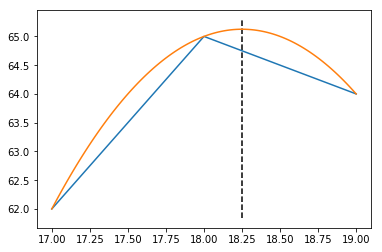

In [76]:
x3 = np.array([17, 18, 19])
y3 = np.array([62, 65, 64])

plt.plot(x3, y3)

a, b, c = find_parabola_coeffs(x3, y3)

xx = np.linspace(x3[0], x3[2], num=100)
yy = a*xx**2 + b*xx + c

plt.plot(xx, yy)

s_fracpeak = find_parabola_peak_loc(a, b)

plt.vlines(s_fracpeak, *plt.gca().get_ylim(), linestyle='dashed')


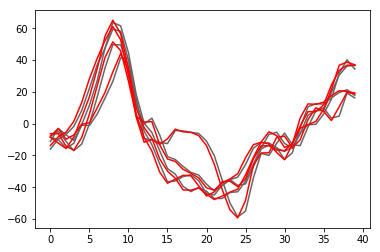

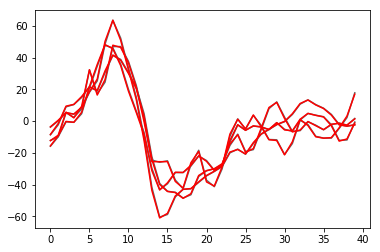

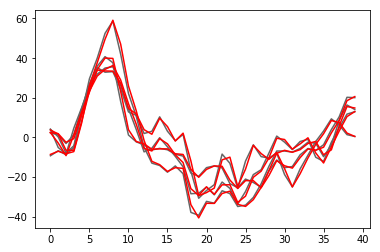

In [77]:
for waveform in waveforms:
    plt.plot(waveform, c='0.4')
    plt.plot(align_waveform_to_peak(waveform), c='r')
    plt.show()

In [38]:
peak_channel

0

In [58]:
# waveforms has shape (N, 40, 4)
# each waveform has shape (40, 4)
waveform = waveforms[0]
num_channels = waveform.shape[1]
i_intpeaks = np.argmax(waveform, axis=0)
peak_vals = waveforms[2][i_intpeaks.squeeze(), range(num_channels)]
peak_channel = np.argmax(peak_vals)
i_intpeak = i_intpeaks[peak_channel]

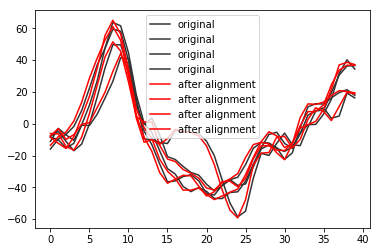

In [61]:
new_wf = interp_around_peak(waveform, 
                   i_intpeak=i_intpeak, 
                   channel=peak_channel, 
                   s_before=8, 
                   s_after=32, 
                   pad=False, 
                   kind='cubic')

plt.plot(waveform, color='0.2', label='original')
plt.plot(new_wf, color='r', label='after alignment')
plt.legend()

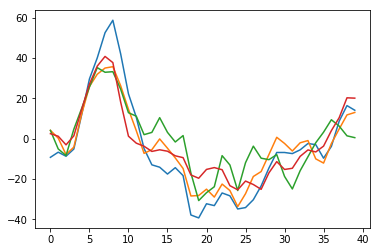

In [15]:
plt.plot(waveforms[2])

In [4]:
waveforms = np.array([[[-15.96211649,  -7.93717821, -11.14979167,  -8.44511693],
        [ -9.72276856,  -4.75132024,  -2.93895664,  -9.99604699],
        [ -6.69643085, -11.12411062,  -7.00155109, -15.42326551],
        [ -1.74094395, -16.97077596, -10.50007   , -12.33472647],
        [  8.19151052, -12.87057961,  -0.98750775,  -0.69642707],
        [ 22.30552197,  -0.16527924,  -1.07369764,  11.61760524],
        [ 37.04576203,  16.91821802,   6.06302522,  27.16928068],
        [ 47.43855295,  35.07602991,  16.16944511,  47.58273601],
        [ 59.46381686,  49.64874825,  26.6045229 ,  63.67649804],
        [ 58.13936618,  49.55963845,  41.46536218,  61.54786828],
        [ 39.88947541,  35.76883449,  40.86108587,  44.61336607],
        [ 14.5211814 ,  11.63585376,  15.84570099,  18.29048987],
        [ -4.58333716,  -0.25229978,  -9.49946685,   0.32759637],
        [-13.20921343,   3.46339702, -10.06489181,  -5.55753264],
        [-25.24322639,  -7.09787681, -11.76343052, -17.03903657],
        [-36.51478896, -20.68942276, -12.46209241, -28.2252488 ],
        [-36.04399266, -22.52620098,  -4.30831713, -31.69426674],
        [-33.25731013, -26.89409704,  -4.53481024, -39.43068428],
        [-32.07145251, -30.66115412,  -5.40062619, -42.70908433],
        [-35.87739473, -32.29479009,  -6.16473858, -40.18359632],
        [-43.99785705, -38.02952903, -10.96903094, -42.52585963],
        [-44.86217581, -42.27535002, -20.12625593, -46.97890501],
        [-38.70659691, -39.05634698, -35.26992104, -47.05339862],
        [-35.08611782, -35.20486265, -49.82253596, -43.26806264],
        [-38.80889875, -33.68705143, -58.58157955, -42.82104438],
        [-37.89321286, -25.73398077, -55.01216761, -36.1964531 ],
        [-27.17245539, -15.41176589, -34.23358541, -25.38412998],
        [-15.92892843, -11.80104036, -18.65605629, -15.21346446],
        [-13.30387462, -12.13460087, -19.95701455,  -6.74444746],
        [-15.49036702, -15.10689546, -12.2906933 ,  -5.37417036],
        [-17.43633231, -22.45108886,  -5.89370468, -12.38604872],
        [-14.6314074 , -18.29729059, -13.19029005, -15.53116731],
        [ -6.40359723,  -2.57883514, -13.8096839 ,  -5.98522952],
        [  5.32526537,  10.58939241,  -2.12327914,  -0.63382874],
        [  8.11878283,  12.60009653,   8.05240755,  -0.42672615],
        [  8.46925923,  12.31256066,   9.96643015,   6.00507888],
        [ 19.50946525,  16.23054276,   3.46632989,  15.37314081],
        [ 30.57607838,  19.57737641,   4.79945843,  31.7234513 ],
        [ 36.2663114 ,  21.37343577,  19.24782811,  40.17437949],
        [ 36.54346039,  17.83272801,  16.2463911 ,  34.35985163]],

       [[ -3.77089023,  -8.63174114, -12.19924235, -15.83421799],
        [  0.13722368,  -2.31471123,  -9.76669196,  -9.87348256],
        [  5.28008969,   9.02196047,   5.22897797,  -0.4578107 ],
        [  4.41540806,  10.47913927,   2.41127448,  -0.74588334],
        [  8.21115016,  14.91585936,   7.60543614,   4.65906112],
        [ 18.15631258,  21.64283563,  32.29684655,  20.78976379],
        [ 25.38476082,  19.00180658,  17.23701108,  34.6867035 ],
        [ 48.64758383,  30.65594406,  24.59110111,  47.8534854 ],
        [ 63.65685046,  41.43804207,  47.06868596,  46.18471182],
        [ 52.37292274,  38.93131461,  47.0546215 ,  36.05778267],
        [ 33.53085693,  30.68686258,  37.71110762,  20.00524732],
        [ 15.13290856,  21.30104534,  22.58217606,   6.31468471],
        [-10.06799002,   4.72630874,   1.58815736,  -7.15737273],
        [-41.77769867, -22.48581428, -24.59342129, -29.8019571 ],
        [-60.5675348 , -39.34241549, -25.95379316, -43.21400834],
        [-58.88684774, -44.29717011, -25.0570943 , -39.53043363],
        [-47.84762003, -44.90327326, -37.1564604 , -32.45620824],
        [-43.06759569, -48.53613031, -42.67987737, -32.45276629],
        [-42.72364078, -46.46707236, -27.56017818, -28.37137938],
        [-38.64465604, -34.89311821, -18.40427378, -22.04686824],
        [-34.55258416, -31.33151103, -37.27218124, -24.89288871],
        [-31.76270911, -30.10161071, -41.37170228, -30.95005092],
        [-28.76191484, -27.44513142, -30.1165702 , -28.51121218],
        [-20.02517428, -15.39436124,  -9.55582077, -13.38722412],
        [-17.66137892,  -8.20953485,   1.40515465,  -2.3754185 ],
        [-20.8769313 , -19.12697225,  -5.08202904,  -5.73496769],
        [-14.11906299, -17.98457283,   3.63913318,  -3.14662122],
        [ -8.34825438,  -5.55731956,  -2.66864648,  -3.55709631],
        [ -5.3356906 ,   7.85767485, -11.59794871,  -5.41972475],
        [ -2.27347942,  12.12329789, -11.78885358,  -0.98889634],
        [ -0.37366096,   2.49781776, -21.04645225,  -5.18444633],
        [  4.19210102,  -6.50388099, -14.17377375,  -6.41083432],
        [ 10.73427909,  -6.00386166,   0.5984429 ,   0.70602994],
        [ 13.41595049,  -0.39015054,  -2.20344711,   4.84880687],
        [ 10.42822408,  -2.5762773 ,  -9.61354782,   3.72563264],
        [  8.1329547 ,  -5.46064306, -10.70966678,   2.78532604],
        [  4.22500125,  -2.19375928, -10.68528189,  -2.26897168],
        [ -2.09900843,  -1.23483547,  -4.6100498 , -12.14225661],
        [ -3.21638138,  -2.62561642,   2.24733164, -11.8902592 ],
        [ -2.29340103,   1.67321455,  17.85127252,  -0.56017142]],

       [[ -9.21578413,   4.15352254,   4.09944358,   2.50100149],
        [ -6.67793213,   0.29147156,  -5.05934794,   1.2232539 ],
        [ -8.6771177 ,  -7.85244037,  -8.35296977,  -3.03103992],
        [ -5.11817676,  -4.16796549,   4.70785403,   1.42024585],
        [ 11.83519404,  12.17317435,  14.97991409,  14.47391917],
        [ 29.59839968,  25.84226704,  25.57855758,  27.05809371],
        [ 40.01294447,  31.93219492,  35.20204166,  35.95672144],
        [ 52.51956825,  35.00929526,  32.91556002,  40.76333357],
        [ 58.68549064,  35.67626765,  33.20239454,  37.70026261],
        [ 42.02969771,  26.25513819,  24.53006558,  18.15976444],
        [ 22.23082384,  14.56371944,  12.88379436,   1.24564314],
        [ 10.66303926,   4.02260968,  11.16432315,  -2.19812636],
        [ -4.87710132,  -7.25653521,   2.00895719,  -3.73419681],
        [-12.94397875,  -5.42281742,   3.12937374,  -6.2978763 ],
        [-14.11788029,  -0.11461487,  10.42340724,  -5.48363436],
        [-17.50734971,  -4.70952852,   3.14674855,  -6.19320872],
        [-14.34448599,  -9.53492926,  -1.62124442,  -8.47056981],
        [-18.27910234, -14.75741932,   1.55794033,  -9.38016711],
        [-37.78481182, -28.36564001, -17.00255685, -17.95285751],
        [-39.23573099, -28.13811174, -30.64708164, -19.58292804],
        [-32.22176021, -24.99459202, -26.73409293, -15.20624805],
        [-33.1403143 , -28.9131487 , -23.79247564, -14.3077372 ],
        [-26.87813849, -22.47393761,  -8.39355312, -15.3612655 ],
        [-28.29414361, -25.68016257, -13.02228523, -23.27002666],
        [-34.80630842, -33.64082039, -25.66336455, -25.3118005 ],
        [-34.11708788, -27.2367094 , -11.88101688, -20.97721443],
        [-30.22791924, -18.71800281,  -3.68587878, -22.69074571],
        [-23.39257726, -16.26792756,  -9.64926952, -25.07587363],
        [-14.52355134,  -7.8350753 , -10.38111883, -16.90133427],
        [ -6.82849365,   0.69671936,  -7.88059292, -11.3396803 ],
        [ -6.82340301,  -2.35125844, -18.6796833 , -15.23168164],
        [ -7.3704659 ,  -6.09632152, -24.88961335, -14.64390395],
        [ -5.51450355,  -2.02221061, -15.84646334,  -8.7451593 ],
        [ -2.37617754,  -0.91950933,  -8.92774877,  -5.55260068],
        [ -2.94132582,  -9.97888295,  -1.99074862,  -6.56121248],
        [ -9.65833339, -12.07138056,   3.23639853,  -3.67107675],
        [ -3.81661652,  -2.40567441,   9.39422485,   3.9984238 ],
        [  8.69837225,   4.80660279,   6.23240559,  10.41429694],
        [ 16.39824981,  11.78518887,   1.4293144 ,  20.26339221],
        [ 14.10139492,  12.99649569,   0.52559519,  20.09283889]]])

In [12]:
a_b_c

array([  -2.,   73., -601.])

In [81]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

In [82]:
import jagular as jag

In [83]:
file_list = ['../sample_data/sample_data_1.rec',
             '../sample_data/sample_data_3.rec',
             '../sample_data/sample_data_4.rec',
             '../sample_data/sample_data_5.rec',
             '../sample_data/sample_data_2.rec'
            ]

jfm = jag.io.JagularFileMap(file_list)

print(jfm)

<JagularFileMap: 5 files spanning 9:45:54:849 hours (missing 52:19:480 minutes)> at 0x1f3a7dbd6a0


In [84]:
ch_out_prefix = ''
ch_out_files = [ch_out_prefix + 'ch.' + str(n).zfill(4) + '.raw' for n in range(jfm._reader.n_spike_channels)]

In [87]:
#TODO: make filenames configurable
#TODO: warn if files already exist, or if we cannot create them (this latter one should be handled automatically)

from contextlib import ExitStack

with ExitStack() as stack:
    ts_file = stack.enter_context(open('timestamps.raw', 'wb+'))
    ch_files = [stack.enter_context(open(fname, 'wb+')) for fname in ch_out_files]
    
    for ii, (ts, all_ch_data) in enumerate(jfm.read_stitched_files(block_size=4)):
        num_packets = len(ts)

        my_ts_struct = struct.Struct('<%dI' % num_packets)
        my_ch_struct = struct.Struct('<%dh' % num_packets)
        ts_packed = my_ts_struct.pack(*ts)
        for ch in range(jfm._reader.n_spike_channels):
            ch_packed = my_ch_struct.pack(*all_ch_data[ch,:])
            # write current channel data of current block to file:
            ch_files[ch].write(ch_packed)
            
        # write timestamps of current block to file:
        ts_file.write(ts_packed)       


In [88]:
# now try to read back some data:

ts_from_file = np.fromfile('timestamps.raw', dtype=np.uint32)

In [89]:
ts_from_file

array([    200917,   55205700,   55205701,   55205702,   55205703,
         55205704,   55205705,   55205706,   55205707,   55205708,
        190383308,  216003235,   45380179,   45380180,   45380181,
         45380182,   45380183,   45380184,   45380185,   45380186,
         45380187,  430419684,  428619684,   55912384,   55912385,
         55912386,   55912387,   55912388,   55912389,   55912390,
         55912391,   55912392,  617928812,  648279793,   23871545,
         23871546,   23871547,   23871548,   23871549,   23871550,
         23871551,   23871552,   23871553,  824383837,  864397337,
         23104817,   23104818,   23104819,   23104820,   23104821,
         23104822,   23104823,   23104824,   23104825, 1054846413], dtype=uint32)

In [90]:
for ii, (ts, ch_data) in enumerate(jfm.read_stitched_files(block_size=5)):
    print(ii, ts)

0 [200917, 55205700, 55205701, 55205702, 55205703]
1 [55205704, 55205705, 55205706, 55205707, 55205708]
2 [190383308, 216003235, 45380179, 45380180, 45380181]
3 [45380182, 45380183, 45380184, 45380185, 45380186]
4 [45380187, 430419684, 428619684, 55912384, 55912385]
5 [55912386, 55912387, 55912388, 55912389, 55912390]
6 [55912391, 55912392, 617928812, 648279793, 23871545]
7 [23871546, 23871547, 23871548, 23871549, 23871550]
8 [23871551, 23871552, 23871553, 824383837, 864397337]
9 [23104817, 23104818, 23104819, 23104820, 23104821]
10 [23104822, 23104823, 23104824, 23104825, 1054846413]


In [45]:
import struct

ch = 5

ch_data = all_ch_data[ch,:]  # get a 1-D array of numbers
arrSize = len(ch_data)

my_struct = struct.Struct('<%dh' % arrSize)

# packed = struct.pack('<iiHHi%df' % arrSize,
#     nSamples, nSampPeriod, nSampSize, nParmKind, arrSize, *flattened)

In [ ]:
flattened = npVect.ravel()  # get a 1-D array of numbers
arrSize = len(flattened)
# pack header, count of numbers, and numbers, all in one call
packed = struct.pack('<iiHHi%df' % arrSize,
    nSamples, nSampPeriod, nSampSize, nParmKind, arrSize, *flattened)

In [16]:
from contextlib import ExitStack

with ExitStack() as stack:
    files = [stack.enter_context(open(fname, 'wb+')) for fname in ch_out_files]
    
    
    flattened = npVect.ravel()  # get a 1-D array of numbers
arrSize = len(flattened)
# pack header, count of numbers, and numbers, all in one call
packed = struct.pack('<iiHHi%df' % arrSize,
    nSamples, nSampPeriod, nSampSize, nParmKind, arrSize, *flattened)

['ch.0000.raw',
 'ch.0001.raw',
 'ch.0002.raw',
 'ch.0003.raw',
 'ch.0004.raw',
 'ch.0005.raw',
 'ch.0006.raw',
 'ch.0007.raw',
 'ch.0008.raw',
 'ch.0009.raw',
 'ch.0010.raw',
 'ch.0011.raw',
 'ch.0012.raw',
 'ch.0013.raw',
 'ch.0014.raw',
 'ch.0015.raw',
 'ch.0016.raw',
 'ch.0017.raw',
 'ch.0018.raw',
 'ch.0019.raw',
 'ch.0020.raw',
 'ch.0021.raw',
 'ch.0022.raw',
 'ch.0023.raw',
 'ch.0024.raw',
 'ch.0025.raw',
 'ch.0026.raw',
 'ch.0027.raw',
 'ch.0028.raw',
 'ch.0029.raw',
 'ch.0030.raw',
 'ch.0031.raw',
 'ch.0032.raw',
 'ch.0033.raw',
 'ch.0034.raw',
 'ch.0035.raw',
 'ch.0036.raw',
 'ch.0037.raw',
 'ch.0038.raw',
 'ch.0039.raw',
 'ch.0040.raw',
 'ch.0041.raw',
 'ch.0042.raw',
 'ch.0043.raw',
 'ch.0044.raw',
 'ch.0045.raw',
 'ch.0046.raw',
 'ch.0047.raw',
 'ch.0048.raw',
 'ch.0049.raw',
 'ch.0050.raw',
 'ch.0051.raw',
 'ch.0052.raw',
 'ch.0053.raw',
 'ch.0054.raw',
 'ch.0055.raw',
 'ch.0056.raw',
 'ch.0057.raw',
 'ch.0058.raw',
 'ch.0059.raw',
 'ch.0060.raw',
 'ch.0061.raw',
 'ch.006

In [6]:

for ii, (ts, ch_data) in enumerate(jfm.read_stitched_files(block_size=5)):
    print(ii, ts)

0 [200917, 55205700, 55205701, 55205702, 55205703]
1 [55205704, 55205705, 55205706, 55205707, 55205708]
2 [190383308, 216003235, 45380179, 45380180, 45380181]
3 [45380182, 45380183, 45380184, 45380185, 45380186]
4 [45380187, 430419684, 428619684, 55912384, 55912385]
5 [55912386, 55912387, 55912388, 55912389, 55912390]
6 [55912391, 55912392, 617928812, 648279793, 23871545]
7 [23871546, 23871547, 23871548, 23871549, 23871550]
8 [23871551, 23871552, 23871553, 824383837, 864397337]
9 [23104817, 23104818, 23104819, 23104820, 23104821]
10 [23104822, 23104823, 23104824, 23104825, 1054846413]


In [28]:
jag.io.JagularFileMap('../sample_data/sample_data_1.rec')

<JagularFileMap: 1 files spanning 1:45:39:413 hours (missing 0.0 milliseconds)> at 0x1f92107c278

In [29]:
jfm.timestamps

array([[  6.69723333e+00,   6.34611027e+03],
       [  7.20010783e+03,   1.43473228e+04],
       [  1.42873228e+04,   2.05976271e+04],
       [  2.16093264e+04,   2.74794612e+04],
       [  2.88132446e+04,   3.51615471e+04]])

In [30]:
jfm.timesamples

array([[    200917,  190383308],
       [ 216003235,  430419684],
       [ 428619684,  617928812],
       [ 648279793,  824383837],
       [ 864397337, 1054846413]])

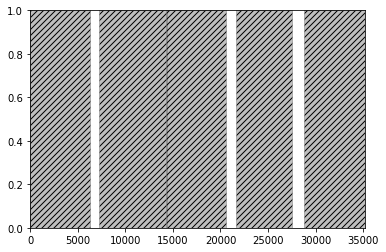

In [31]:
ax = jfm.plot()
# ax.set_xlim(0, 300);

In [32]:
jfm._samples_within_bounds(2853122, 7093204 )

True

In [33]:
jfm._time_within_bounds(100, 250)

True

In [34]:
print("duration including gaps: {}".format(jfm.duration_w_gaps))
print("duration excluding gaps: {}".format(jfm.duration_wo_gaps))

duration including gaps: 9:45:54:849 hours
duration excluding gaps: 8:53:35:369 hours


In [83]:
from contextlib import ExitStack

with open('test1', 'w') as f:
    f.write('f1b1f1b2f1b3f1b4')
    
with open('test2', 'w') as f:
    f.write('f2b1f2b2f2b3f2b4')
    
with open('test3', 'w') as f:
    f.write('f3b1f3b2')
    
with open('test4', 'w') as f:
    f.write('f4b1f4b2f4b3f4b4f4b5')
    
filenames = ['test1', 'test2', 'test3', 'test4']

from contextlib import ExitStack

def read_stitched_files(nch=2):
    with ExitStack() as stack:
        files = [stack.enter_context(open(fname, 'r')) for fname in filenames]
        ii=0
        while True:
            try:
                chunk = files[ii].read(4*nch)
                if 0 < len(chunk) < 4*nch:
                    # chunk size could not be filled from current file, so move onto next file
                    ii+=1
                    chunkB = files[ii].read(4*int(nch-len(chunk)/4))
                    chunk = chunk + chunkB
                if chunk:
                    yield chunk
                else:
                    ii+=1
            except IndexError:
                return
                       
for chunk in read_stitched_files(3):
    print(chunk)

f1b1f1b2f1b3
f1b4f2b1f2b2
f2b3f2b4f3b1
f3b2f4b1f4b2
f4b3f4b4f4b5


In [82]:
with open('test1', 'w') as f:
    f.write('f1b1f1b2f1b3f1b4')
with open('test2', 'w') as f:
    f.write('f2b1f2b2f2b3f2b4')
with open('test3', 'w') as f:
    f.write('f3b1f3b2')   
with open('test4', 'w') as f:
    f.write('f4b1f4b2f4b3f4b4f4b5')

print('')
print('One symbol at a time:')
print('=======================')
for chunk in read_stitched_files(1):
    print(chunk)
    
print('')
print('Two symbols at a time:')
print('=======================')
for chunk in read_stitched_files(2):
    print(chunk)
    
print('')
print('Three symbols at a time:')
print('=======================')
for chunk in read_stitched_files(3):
    print(chunk)
    
print('')
print('Four symbols at a time:')
print('=======================')
for chunk in read_stitched_files(4):
    print(chunk)
    
print('')
print('Five symbols at a time:')
print('=======================')
for chunk in read_stitched_files(5):
    print(chunk)
    
print('')
print('Six symbols at a time:')
print('=======================')
for chunk in read_stitched_files(6):
    print(chunk)


One symbol at a time:
f1b1
f1b2
f1b3
f1b4
f2b1
f2b2
f2b3
f2b4
f3b1
f3b2
f4b1
f4b2
f4b3
f4b4
f4b5

Two symbols at a time:
f1b1f1b2
f1b3f1b4
f2b1f2b2
f2b3f2b4
f3b1f3b2
f4b1f4b2
f4b3f4b4

Three symbols at a time:
f1b1f1b2f1b3
f1b4f2b1f2b2
f2b3f2b4f3b1
f3b2f4b1f4b2
f4b3f4b4f4b5

Four symbols at a time:
f1b1f1b2f1b3f1b4
f2b1f2b2f2b3f2b4
f3b1f3b2f4b1f4b2

Five symbols at a time:
f1b1f1b2f1b3f1b4f2b1
f2b2f2b3f2b4f3b1f3b2
f4b1f4b2f4b3f4b4f4b5

Six symbols at a time:
f1b1f1b2f1b3f1b4f2b1f2b2
f2b3f2b4f3b1f3b2
